In [238]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


# Producing a PCA 
This code will take an input of a featurematrix with an Id column and intensities for each sample with the names PX_tXh

In [239]:
df = pd.DataFrame
software = input("What software is being used:")

if software.lower() == "mzmine":
# Importing the data - MZmine
    df = pd.read_csv(r"C:\Users\adamg\OneDrive - The University of Liverpool\Project Work\MZmine\MZmine_Feature_Matrix.csv")
elif software.lower() == "xcms":
# Importing the data - XCMS
    df = pd.read_csv(r"C:\Users\adamg\OneDrive - The University of Liverpool\Project Work\XCMS\XCMS_Feature_Matrix.csv")
elif software.lower() == "maldiquant":
# Importing the data - MALDIquant
    df = pd.read_csv(r"C:\Users\adamg\OneDrive - The University of Liverpool\Project Work\MALDIquant\MALDIquant_Feature_Matrix.csv")
elif software.lower() == "dimspy":
# Importing the data - DIMSpy
    df = pd.read_csv(r"C:\Users\adamg\OneDrive - The University of Liverpool\Project Work\DIMSpy\DIMSpy_Feature_Matrix.csv")
else:
    print("invalid software - please re run the PCA visualiser")


df.head()

,id,batch01_C01_rep01,batch01_C01_rep02,batch01_C01_rep03,batch01_C02_rep01,batch01_C02_rep02,batch01_C02_rep03,batch01_C03_rep01,batch01_C03_rep02,batch01_C03_rep03,...,batch08_S07_rep03,batch08_S08_rep01,batch08_S08_rep02,batch08_S08_rep03,batch08_S09_rep01,batch08_S09_rep02,batch08_S09_rep03,batch08_S10_rep01,batch08_S10_rep02,batch08_S10_rep03
0,FT001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,572640.459832,NaN,NaN
1,FT002,NaN,NaN,373640.917892,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,549400.14566,535035.178503,NaN,644929.29996,NaN,703161.151574,NaN,NaN,NaN
2,FT003,NaN,369510.323499,NaN,447621.171961,476478.834253,354235.125403,375607.57823,375008.250875,380730.085859,...,581284.296821,NaN,NaN,541497.140919,NaN,569306.602588,NaN,NaN,537894.111221,608239.848752
3,FT004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FT005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
date = input("Enter the date (For naming)")

# Data cleaning
The data needs to be cleaned first. This means removing features that are only present in <10% of the samples, filling in missing values through k-nearest neighbour machine learning and scaling the data 

## Removing rows with low amounts of data

In [241]:
# Before cleaning
df.shape

(136, 519)

In [242]:
threshold = 0.1

# Finds the number of columns with data in 
data_cols = df.notna().sum(axis=1)

df = df[data_cols >= df.shape[1]*threshold]

In [243]:
# After filtering
df.shape

(33, 519)

## Getting Sample Names

In [244]:
# Extracting the sample type, batch and replicate information 
labels = []
batches = []
sample_info = []
animals = []
samples = []
for col in df.columns[1:]:
  parts = col.split('_')
  sample_info.append((parts[0], parts[1], int(parts[2][3:]))) 

  batches.append(int(parts[0][-1]))
  animals.append(parts[1][:1])
  
  samples.append(parts[1])



shapes = {'Q': 'o', 'C': 's', 'S': '^'}

transposed_df = df[2:].T
transposed_df = transposed_df.rename(columns =  transposed_df.iloc[0])
transposed_df = transposed_df.iloc[1:]
# transposed_df

sample_info

[('batch01', 'C01', 1),
 ('batch01', 'C01', 2),
 ('batch01', 'C01', 3),
 ('batch01', 'C02', 1),
 ('batch01', 'C02', 2),
 ('batch01', 'C02', 3),
 ('batch01', 'C03', 1),
 ('batch01', 'C03', 2),
 ('batch01', 'C03', 3),
 ('batch01', 'C04', 1),
 ('batch01', 'C04', 2),
 ('batch01', 'C04', 3),
 ('batch01', 'C05', 1),
 ('batch01', 'C05', 2),
 ('batch01', 'C05', 3),
 ('batch01', 'C06', 1),
 ('batch01', 'C06', 2),
 ('batch01', 'C06', 3),
 ('batch01', 'C07', 1),
 ('batch01', 'C07', 2),
 ('batch01', 'C07', 3),
 ('batch01', 'C08', 1),
 ('batch01', 'C08', 2),
 ('batch01', 'C08', 3),
 ('batch01', 'C09', 1),
 ('batch01', 'C09', 2),
 ('batch01', 'C09', 3),
 ('batch01', 'C10', 1),
 ('batch01', 'C10', 2),
 ('batch01', 'C10', 3),
 ('batch01', 'QC01', 1),
 ('batch01', 'QC01', 2),
 ('batch01', 'QC01', 3),
 ('batch01', 'QC02', 1),
 ('batch01', 'QC02', 2),
 ('batch01', 'QC02', 3),
 ('batch01', 'QC03', 1),
 ('batch01', 'QC03', 2),
 ('batch01', 'QC03', 3),
 ('batch01', 'QC04', 1),
 ('batch01', 'QC04', 2),
 ('ba

# Scaling the data

In [245]:
x = StandardScaler().fit_transform(transposed_df)

## Filling in missing values 
Using k-nearest neighbour

In [246]:
# Can adjust the number of neighbours
num_neighbours = 2

imputer = KNNImputer(n_neighbors=num_neighbours, weights="uniform")

x = imputer.fit_transform(x)
x

array([[-0.35940404,  0.05379289,  0.31351406, ..., -0.76674922,
         0.03398071,  0.02115597],
       [ 0.3772059 ,  1.36168665, -0.47078315, ...,  0.07507636,
         0.2577486 , -0.92356275],
       [ 0.56017154,  0.01466886,  0.85087379, ..., -0.71666318,
         0.54592139, -1.03434658],
       ...,
       [ 1.03725608,  0.63379653,  1.72675855, ...,  0.84445558,
         1.01118728, -0.33377022],
       [ 1.39391032,  0.31113771,  1.72675855, ...,  0.87524864,
         0.59966372,  0.96429585],
       [ 0.35642918, -0.35278052, -0.0684931 , ..., -0.388937  ,
         0.62527489, -0.28736686]])

# Performing PCA analysis

In [247]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(x)
principalDf = pd.DataFrame(data=pca_data, columns=["Principal Component 1","Principal Component 2"])

principalDf["Animal"] = animals
principalDf["Sample"] = samples
principalDf["Batch"] = batches

principalDf = principalDf[principalDf["Animal"] != "B"]

principalDf

,Principal Component 1,Principal Component 2,Animal,Sample,Batch
0,-4.523564,-0.865163,C,C01,1
1,-3.919368,-1.968690,C,C01,1
2,-3.918880,-2.432886,C,C01,1
3,-3.020829,-1.470780,C,C02,1
4,-3.256597,-1.078803,C,C02,1
...,...,...,...,...,...
513,7.155825,0.430958,S,S09,8
514,6.881799,0.337770,S,S09,8
515,7.563370,0.385143,S,S10,8
516,8.136640,0.762942,S,S10,8


In [248]:
print("labels", len(labels))
print("batches", len(batches))
print("pca_data", len(pca_data))
print("colours", len(colors))
print("shape", len(shapes))

labels 0
batches 518
pca_data 518
colours 192
shape 3


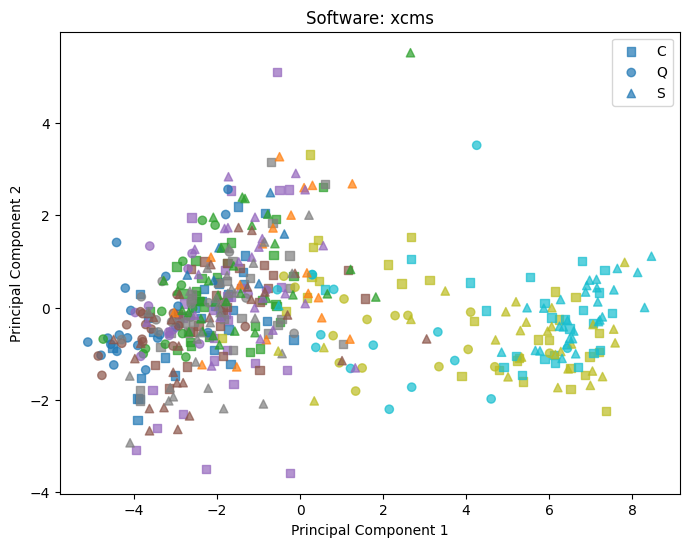

In [255]:
animal_to_shape = {'Q': 'o', 'C': 's', 'S': '^'}

cmap = plt.cm.tab10

fig, ax = plt.subplots(figsize=(8, 6))
for animal, data in principalDf.groupby('Animal'):
    color_indices = data['Batch'] - 1  # Adjust for 0-based indexing
    colors = cmap(color_indices / (len(principalDf['Batch'].unique()) - 1))  # Normalize color indices
    ax.scatter(
        data['Principal Component 1'], data['Principal Component 2'], c=colors,
        label=animal, marker=animal_to_shape[animal], alpha=0.7
    )


title = f"Software: {software}"# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title(title)

# Add legend
ax.legend()

# Show the plot
plt.show()
